#### 0. Base
Laboratory Value Data Extract를 위해 선정한 ITEMID의 유효성 검증을 위한 작업

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

#### 1. time-series data 유효성 판단

In [94]:
df = pd.read_csv("~/project/MIMIC-III/Data/ITEMLIST.csv")
df['CHARTDATE'] = pd.to_datetime(df['CHARTDATE']) #연속되는 날짜 파악하기 위해 type 변경
df.sort_values(["SUBJECT_ID","HADM_ID", "CHARTDATE"], inplace = True)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,SPEC_ITEMID,SPEC_TYPE_DESC,ORG_ITEMID,ORG_NAME,ISOLATE_NUM,AB_ITEMID,AB_NAME,DILUTION_TEXT,DILUTION_COMPARISON,DILUTION_VALUE,INTERPRETATION
21,13,3,145834,2101-10-21,2101-10-21 04:30:00,70062.0,SPUTUM,80075.0,YEAST,1.0,NaN,NaN,NaN,NaN,NaN,NaN
22,21,4,185777,2191-03-16,2191-03-16 12:30:00,70062.0,SPUTUM,80260.0,POSITIVE FOR PNEUMOCYSTIS CARINII,1.0,NaN,NaN,NaN,NaN,NaN,NaN
23,31,4,185777,2191-03-19,2191-03-19 15:00:00,70062.0,SPUTUM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,38,9,150750,2149-11-10,2149-11-10 09:23:00,70062.0,SPUTUM,80023.0,STAPH AUREUS COAG +,1.0,90002.0,PENICILLIN,=>0.5,=>,1.0,R
25,39,9,150750,2149-11-10,2149-11-10 09:23:00,70062.0,SPUTUM,80058.0,GRAM NEGATIVE ROD(S),1.0,NaN,NaN,NaN,NaN,NaN,NaN


##### 1-1. time-series에 data count, mean column 추가

In [111]:
# 중복되지 않는 date의 개수를 계산하는 함수
def count_unique_dates(group):
    return len(group['CHARTDATE'].unique())

# SUBJECT_ID, HADM_ID, CHARTDATE 칼럼을 그룹바이 한 다음 각 그룹에 count_unique_dates 함수 적용
unique_date_counts = df.groupby(['SUBJECT_ID', 'HADM_ID', 'CHARTDATE']).apply(count_unique_dates).reset_index(name='COUNT')

# SUBJECT_ID, HADM_ID 칼럼별로 그룹바이 한 다음 count 칼럼의 합을 계산
total_counts = unique_date_counts.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False)['COUNT'].sum()

# MEAN 칼럼 추가
total_counts['MEAN'] = unique_date_counts.groupby(['SUBJECT_ID', 'HADM_ID'])['CHARTDATE'].apply(lambda x: x.diff().mean()).values
# datetime 데이터의 결측치인 NaT를 0day로 변경
total_counts['MEAN'] = total_counts['MEAN'].fillna(pd.Timedelta(0)).apply(lambda x: pd.Timedelta(x).days)
# day만 남기기!
total_counts['MEAN'] = pd.to_timedelta(total_counts['MEAN'], unit='D')
total_counts['MEAN'] = total_counts['MEAN'].apply(lambda x: int(str(x).split()[0]))


# 인덱스 재설정
total_counts = total_counts.reset_index(drop=True)

# 결과 출력
total_counts

,SUBJECT_ID,HADM_ID,COUNT,MEAN
0,3,145834,1,0
1,4,185777,2,3
2,9,150750,1,0
3,12,112213,2,1
4,23,124321,1,0
...,...,...,...,...
13042,99923,192053,1,0
13043,99934,176121,1,0
13044,99937,129380,2,1
13045,99955,108494,2,3


In [73]:
# # total_counts df의 결과가 맞는지 육안으로 확인하기 위한 코드, 무시해도 됨
# df.sort_values(["SUBJECT_ID","HADM_ID", "CHARTDATE"])[:23]

##### 1-2. 전체 time-series count plot

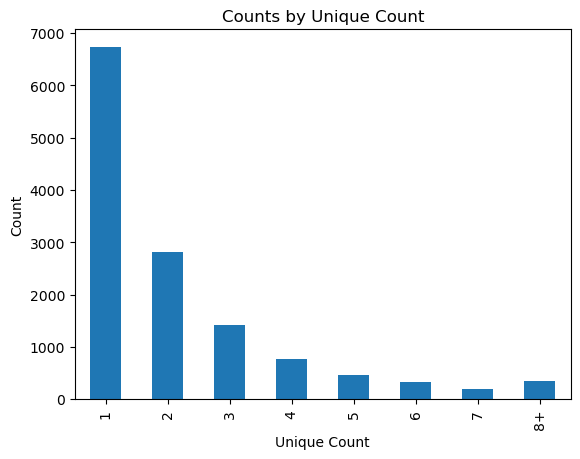

COUNT
1     6731
2     2806
3     1421
4      776
5      452
6      322
7      195
8+     344
dtype: int64


In [152]:
# total_counts df의 count column으로 plot 찍어보기
# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_count = total_counts.groupby('COUNT').size()

# Count가 7번 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_count = count_by_count.groupby(count_by_count.index.where(count_by_count > 190, '8+')).sum()

# bar 그래프 그리기
count_by_count.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Count')
plt.xlabel('Unique Count')
plt.ylabel('Count')

# 그래프 출력
plt.show()

print(count_by_count)

##### 1-3. 전체 time-series mean plot

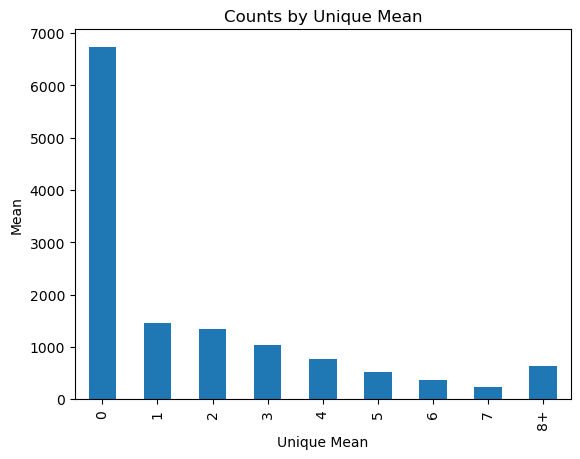

MEAN
0     6731
1     1455
2     1335
3     1030
4      759
5      511
6      372
7      223
8+     631
dtype: int64


In [151]:
# total_counts df의 mean column으로 plot 찍어보기

# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_mean = total_counts.groupby('MEAN').size()

# MEAN이 7일 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_mean = count_by_mean.groupby(count_by_mean.index.where(count_by_mean > 200, '8+')).sum()

# bar 그래프 그리기
count_by_mean.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Mean')
plt.xlabel('Unique Mean')
plt.ylabel('Mean')

# 그래프 출력
plt.show()

print(count_by_mean)

##### 1-4.Respiratory 환자의 time-series count plot(7,631->4,885명)

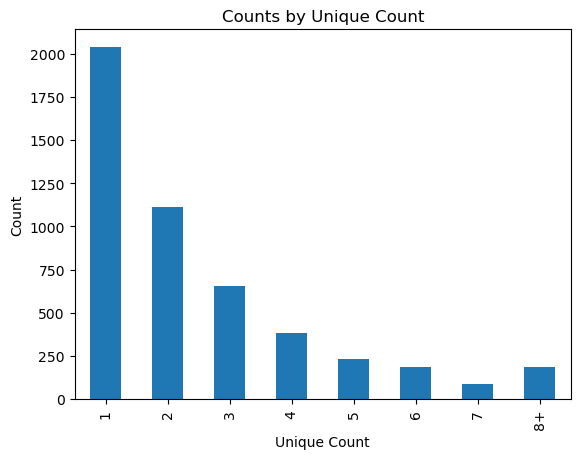

COUNT
1     2038
2     1115
3      656
4      385
5      234
6      185
7       89
8+     183
dtype: int64


In [150]:
# Respiratory 환자의 경우 유효성 검사
df = pd.read_csv("~/project/MIMIC-III/Data/SUBJECTID.csv")
merged_df = pd.merge(total_counts, df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_count = merged_df.groupby('COUNT').size()

# Count가 7번 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_count = count_by_count.groupby(count_by_count.index.where(count_by_count > 80, '8+')).sum()

# bar 그래프 그리기
count_by_count.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Count')
plt.xlabel('Unique Count')
plt.ylabel('Count')

# 그래프 출력
plt.show()

print(count_by_count)

##### 1-5.Respiratory 환자의 time-series mean plot(7,631->4,885명)

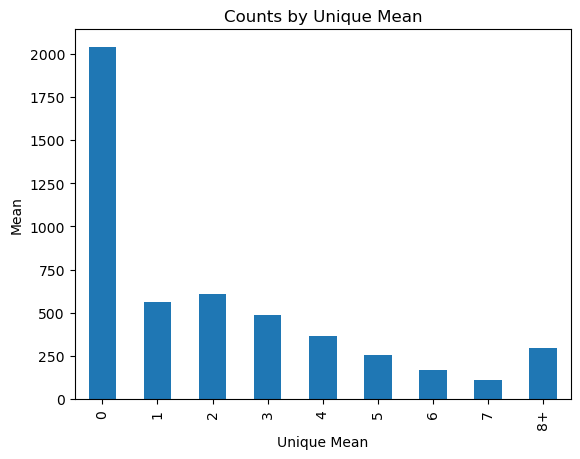

MEAN
0     2038
1      561
2      607
3      487
4      364
5      256
6      167
7      110
8+     295
dtype: int64


In [149]:
# count 칼럼을 기준으로 그룹을 지어서 그룹마다의 개수를 구함
count_by_mean = merged_df.groupby('MEAN').size()

# MEAN이 7일 이상인 경우 '8+'로 표시하여 카운트를 합침
count_by_mean = count_by_mean.groupby(count_by_mean.index.where(count_by_mean > 100, '8+')).sum()

# bar 그래프 그리기
count_by_mean.plot(kind='bar')

# 그래프 꾸미기
plt.title('Counts by Unique Mean')
plt.xlabel('Unique Mean')
plt.ylabel('Mean')

# 그래프 출력
plt.show()

print(count_by_mean)

#### 2. ID에 따라 결측치 여부 확인

,SUBJECT_ID,HADM_ID
0,20936,157548
1,25600,122994
2,79166,177249
3,75775,101668
4,26861,115381
...,...,...
7626,48806,116558
7627,19067,192309
7628,40370,199999
7629,47335,161669


#### 1. ID를 고려했을 때 Dense한 ITEMID